**Motivation:** Performing the Natural Language Processing task of *emotion detection* with *BERT* (Bidirectional Encoder Representations from Transformers). BERT is a pre-trained language model able to understand language. It is for example used in Google search, for translation services, next sentence prediction and text classification. It can be fine-tuned (retrained) to perform a specific task, like in this case, emotion detection.

In this task we pass sentences like 'My anger is boiling over' to BERT and a classifier and train until the model is able to make accurate predictions whether the sentence is *emotional* or *non-emotional*.


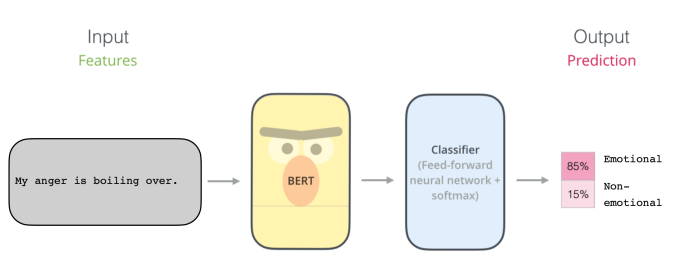

Image source:  https://jalammar.github.io/illustrated-transformer (modified)


Fine-tuning BERT consists of two steps:

1.) Load and tokenize the data
2.) Train and evaluate the data

In [ ]:
#let's import the machine learning library torch
import torch 
#

In [ ]:
"""we want to train out models on a GPU (Graphics Processing Unit), so we use CUDA (Compute Unified Device Architecture)
that gives us access to the GPU if available. Otherwise the CPU is used."""
if torch.cuda.is_available:
  device = torch.device("cuda")
  print(torch.cuda.get_device_name(0))

else: 
  device = torch.device("cpu")

Tesla T4


In [ ]:
#we use transformers from the Huggingface library in order to download the BERT components https://huggingface.co/docs/transformers/installation
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#connect to the google drive where the data is stored 
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import the data as a dataframe (2-D table data)
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/Workshop NLP/emotion_data.csv")
print('Number of sentences: {: }\n'.format(df.shape[0]))



Number of sentences:  1000



The sources of the used texts are:

Alm, E. C. O. (2008). Affect in* text and speech. University of Illinois at Urbana-Champaign.

Alm, C. O., Roth, D., & Sproat, R. (2005, October). Emotions from text: machine learning for text-based emotion prediction. In Proceedings of human language technology conference and conference on empirical methods in natural language processing, pp. 579-586.

Scherer, K. R., & Wallbott, H. G. (1994). Evidence for universality and cultural variation of differential emotion response patterning. Journal of personality and social psychology, 66(2), 310.

Strapparava, C., & Mihalcea, R. (2007, June). Semeval-2007 task 14: Affective text. In Proceedings of the Fourth International Workshop on Semantic Evaluations (SemEval-2007), pp. 70-74.

Mohammad, S., Bravo-Marquez, F., Salameh, M., & Kiritchenko, S. (2018, June). Semeval-2018 task 1: Affect in tweets. In Proceedings of the 12th international workshop on semantic evaluation, pp. 1-17.

Chatterjee, A., Narahari, K. N., Joshi, M., & Agrawal, P. (2019, June). SemEval-2019 task 3: EmoContext contextual emotion detection in text. In Proceedings of the 13th international workshop on semantic evaluation, pp. 39-48.


In [ ]:
#retrieve sentences and labels
sentences = df.Sentence.values
labels = df.Emotion.values


We train the model with labeled data. As data we have sentences labeled with the values 0 and 1. 0 meaning *emotional* and 1 *non-emotional*.
During the training phase the model is trained with the labeled train data.  After each episode (full pass of train data through the model), the model is evaluated with a validation data set.

In [ ]:
#retrieve train and validation dataset

#get train dataset as dataframe
train_dataset_df = df.loc[df['Set'] == 'train']
print('train_dataset_df' + f'{train_dataset_df}')

#get validation dataset as dataframe
validation_dataset_df = df.loc[df['Set'] == 'dev']
print('validation_dataset_df' + f'{validation_dataset_df}')

#extract sentences from df
train_data = []
for row in train_dataset_df['Sentence']:
    train_data.append(row)

validation_data = []
for row in validation_dataset_df['Sentence']:
    validation_data.append(row)

#extract labels (Emotions) from df
labels_train = []
for row in train_dataset_df['Emotion']:
    labels_train.append(row)

labels_validation = []
for row in validation_dataset_df['Emotion']:
    labels_validation.append(row)

print('len(labels_validation)' + " " + f'{len(labels_validation)}')
print('len(validation_data)' +  " " + f'{len(validation_data)}')
print('len(train_data)' +  " " + f'{len(train_data)}')
print('len(labels_train)' + " " +  f'{len(labels_train)}')



train_dataset_df      Id                                           Sentence            Source  \
0      0                  "You shall have no horse from me.               Alm   
1      1  When my mother decided to clean out my room an...             ISEAR   
2      2               No help  just kiddingBad suggestions  SemEval2019Train   
3      3     U are a bugWhich bug is that?U stupid asswhole  SemEval2019Train   
4      4          I am so sorry !Thank you.I was little sad  SemEval2019Train   
..   ...                                                ...               ...   
993  993  In the neighborhood of Eisenach stretches a ri...               Alm   
996  996  When I was young - 14, I pinched from a store ...             ISEAR   
997  997  Once I had some homework to do and I did not d...             ISEAR   
998  998  It can be opened and explained, so that people...               Alm   
999  999  "I shall be much thinner before springtime, my...               Alm   

       Set 

Our model can't process the entire sentences as we as humans do, as it only understands numerical input. Therefore we use a 'tokenizer' that splits the sentences into its components and turns them into small units, i.e. tokens. 

Important terminology:

- Input ids: numerical representation of the token
- Attention masks: tells the model which parts if the input it should pay attention to
- CLS and SEP token (special tokens): marking beginning and end of a sequence
- Tensor: A tensor is basically an n-d array. 

In [ ]:
from transformers import BertTokenizer

# We load the BERT tokenizer of the pretrained 'bert-base-uncased' model, see https://huggingface.co/bert-base-uncased
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

**From here on the code is based heavily on this amazing tutorial:** Chris McCormick and Nick Ryan. (2019, July 22). BERT Fine-Tuning Tutorial with PyTorch. Retrieved from http://www.mccormickml.com. Cited as 'BERT tutorial' in this notebook.

For further steps we need to determine the maximum sentence length among all sentences.

In [ ]:
max_len = 0

for sent in sentences:

    # tokenize the text and add special tokens indicating beginning of a sequence (`[CLS]`) and seperation `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # determine the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  132


In [ ]:
from torch.utils.data import TensorDataset
# Tokenize all of the sentences of the train data and map the tokens to their word IDs.

input_ids = []
attention_masks = []

# For every sentence...
for sent in train_data:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # the sentence to encode
                        add_special_tokens = True, # add '[CLS]' and '[SEP]' token
                        truncation = True,         # truncation: shorten sentence tensors longer than max length  
                        max_length = 180,          
                        padding = 'max_length',    # padding: fill sentence tensor less than max length 
                        return_attention_mask = True,   # binary tensor giving position of padded indices
                        return_tensors = 'pt',          # return pytorch tensors.
                   )
    
    input_ids.append(encoded_dict['input_ids'])    
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the input_ids and attention_masks into tensors. 
input_ids = torch.cat(input_ids, dim=0) 
print(len(input_ids))

attention_masks = torch.cat(attention_masks, dim=0)
print(len(attention_masks))

labels = torch.tensor(labels_train)
print(len(labels_train))

train_dataset = TensorDataset(input_ids, attention_masks, labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

806
806
806
Original:  "You shall have no horse from me.
Token IDs: tensor([ 101, 1000, 2017, 4618, 2031, 2053, 3586, 2013, 2033, 1012,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   

In [ ]:
# Tokenize the validation data
input_ids = []
attention_masks = []

for sent in validation_data:  
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        truncation = True,
                        max_length = 180,           
                        padding = 'max_length',
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_validation)
print(len(input_ids))
print(len(attention_masks))
print(len(labels_validation))

val_dataset = TensorDataset(input_ids, attention_masks, labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

92
92
92
Original:  "You shall have no horse from me.
Token IDs: tensor([  101,  8038, 10938,  2121,  1996,  2197,  5000, 10760,  2197,  5000,
         9466,  6499,  3835,  3185,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,

Now we create a dataloader which loads data in batches to pass it to BERT.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

# Create the DataLoaders for our training and validation sets.

train_dataloader = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In a next step, we will download the pretrained BERT model, as visualized in the following image (own image):

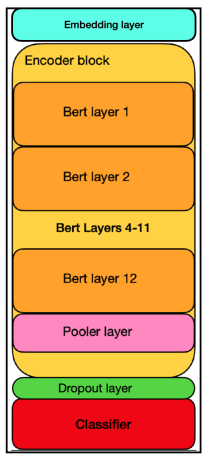

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # binary classification (=2 labels)
    output_attentions = False, 
    output_hidden_states = False, 
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In the above output you could see the details of BERT's architecture. Here is some more theoretical background:

BERT is a special kind of Deep Learning model, also *deep neural net* (DNN).
- a DNN is a neural net with more than one hidden layer 
- a DNN has a hierarchical nature, which enables to abstract from the original raw input
- a DNN's actual learning is achieved via adapting its weights in such a way that the error between the net’s output i.e. the predicted labels and a predefined desired outcome i.e. the ground truth is minimized 
- *loss function*: the function capturing the error
- the direction of weight adaptation needs to be estimated and this is typically achieved by *backpropagation*. Backpropagation enables the information received from the loss function to be passed backwards through the net 
- weights are then adapted via stochastic gradient descent (SGD) methods which are also known as *optimizers* minimizing the objective function 
- the *learning rate* enables that the individual inputs have a balanced impact. Learning develops over a predefined number of *epochs*, i.e. the number of times the same data is passed through the model

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon 
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Here we determine the number of training epochs (one epoch is one pass of of the training data through the model), the total_steps per epoch and create a scheduler organizing all this

epochs = 6

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# accuracy gives the number of correct predictions in relation to all predictions 

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np
import os


# As quoted in the BERT tutorial, this training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set a seed value for reproducability
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store a number of quantities such as training and validation loss, validation accuracy, and timings to visualize later.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # measure duration of the training epoch 
    t0 = time.time()

    # reset loss for this episode
    total_train_loss = 0

    # enter training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)     # input ids 
        b_input_mask = batch[1].to(device)    # attention masks    
        b_labels = batch[2].to(device)        # labels

        # clear any previously calculated gradients 
        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

  
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0. to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure the model performance on the validation set -

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of validation sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# ========================================
#  Save model
# ========================================

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`. These components can then be reloaded using `from_pretrained()`.
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

!cp -r ./model_save/ "/content/drive/My Drive/NLP Workshop/"



======== Epoch 1 / 6 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:20.

  Average training loss: 0.38
  Training epoch took: 0:00:25

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.26
  Validation took: 0:00:01

======== Epoch 2 / 6 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:19.

  Average training loss: 0.22
  Training epoch took: 0:00:24

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.25
  Validation took: 0:00:01

======== Epoch 3 / 6 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:19.

  Average training loss: 0.13
  Training epoch took: 0:00:24

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.30
  Validation took: 0:00:01

======== Epoch 4 / 6 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:19.

  Average training loss: 0.08
  Training epoch took: 0:00:24

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.27
  Validation took: 0:00:01

======== Epoch 5 / 6 ======

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.38,0.26,0.91,0:00:25,0:00:01
2,0.22,0.25,0.90,0:00:24,0:00:01
3,0.13,0.30,0.90,0:00:24,0:00:01
4,0.08,0.27,0.92,0:00:24,0:00:01
5,0.04,0.40,0.90,0:00:24,0:00:01
6,0.04,0.33,0.91,0:00:24,0:00:01


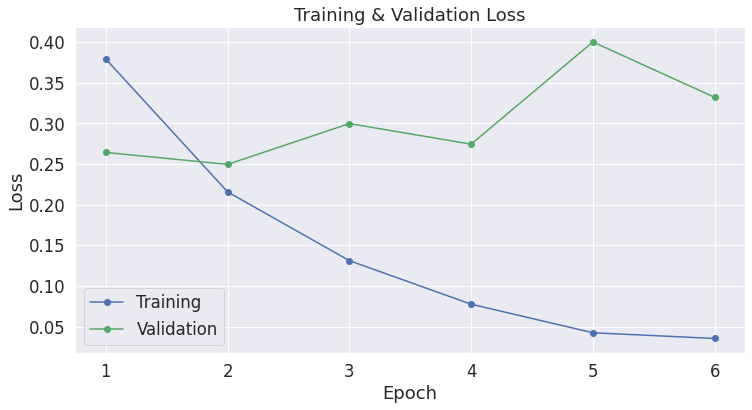

In [ ]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6])

plt.show()

Our model is overfitting! It works very well on the training data (low training loss) but is unable to generalize on new unseen data (high validation loss).

Possible solution: use much larger amount of training data 50.000-100.000 sentences rather than only 1000. 

How come accuracy is quite high? Probably because validation and training data are similar. Given input from a different source, the accuracy is likely to be low. 


